In [1]:
%load_ext autoreload
%autoreload 2 


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import h5py
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from aux_functions import put_gaze_annotation, rgb,angle_to_2d,is_accurate
from random import randint

# 0. Configuraciones

Configuraciones para CUDA

In [3]:
# Configuraciones para CUDA
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device a utilizar:",device)

Device a utilizar: cuda


# 1. Análisis de datos

En esta sección se analizan los siguientes aspectos del dataset:
1. Cantidad de imágenes y participantes
1.  Distribución de los ángulos de mirada en el dataset.

- El dataset se encuentra en un archivo con formato h5 localizado en la carpeta "datasets"
- Para facilitar la carga de datos a pytorch se crea una clase que utiliza torch.Dataset de base y se encuentra en el archivo _datasets.py_

## 1.1. Cantidad de imágenes

In [5]:
with h5py.File('./datasets/MPIIFaceGaze.h5', 'r') as file:

    cant_imagenes = 0
    cant_imagenes_persona = []
    gaze_data = []

    for person_idx in range(len(file)):

        person = f"p{person_idx:02d}"
        dataset = file[person]

        images = dataset["image"]
        gaze = dataset["gaze"]
        pose = dataset["pose"]

        cant_imagenes += len(images)
        cant_imagenes_persona.append(len(images))

        # Almaceno todos los labels de miradas [pitch,yaw] del participante
        for i,g in enumerate(gaze):
            i_key = f"{i:04d}"
            gaze_data.append(np.array(gaze[i_key],dtype=float))

print(f"En el dataset hay: {cant_imagenes} imágenes de {len(cant_imagenes_persona)} personas.")
print(f"Las imágenes por persona son: {cant_imagenes_persona}")

/tmp/ipykernel_1930299/2887136188.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  gaze_data.append(np.array(gaze[i_key],dtype=float))


Vemos que hay 3000 imágenes por cada persona y se tienen 15 sujetos diferentes. Veamos ahora la distribución de los ángulos de la mirada:

## 1.2. Distribución de ángulos de las miradas

En el dataset los ángulos de la mirada están representados por dos valores, pitch y yaw. Estos representan la rotación horizontal y vertical

En la siguiente imágen se ilustran los ángulos:

![head_ref.png](head_ref.png)

Se analizará la distribución entonces de:

- Pitch: Componente asociada al movimiento vertical.
- Yaw: Componente asociada al movimiento horizontal.
- Angle_2d: Proyección del ángulo en 2 dimensiones (para más información ver el archivo aux_functions.py)

In [ ]:
gaze_array = np.array(gaze_data)
pitch_array = gaze_array[:,0]
yaw_array = gaze_array[:,1]
projected_2d_angle_array = angle_to_2d(gaze_array)

### 1.2.1 Pitch

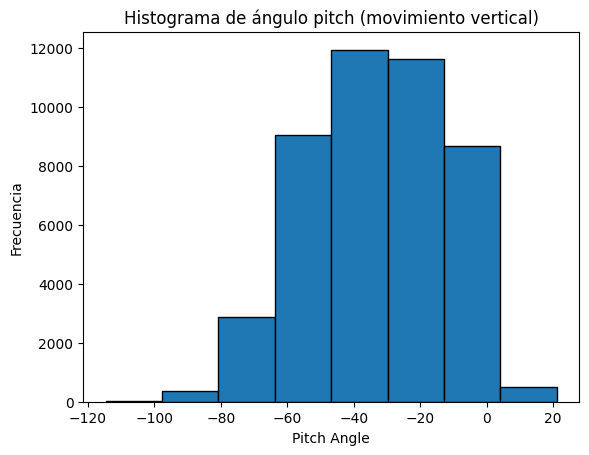

In [ ]:
pitch_array_deg = np.rad2deg(pitch_array*np.pi)
plt.hist(pitch_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo pitch (movimiento vertical)')
plt.show()

### 1.2.2 Yaw

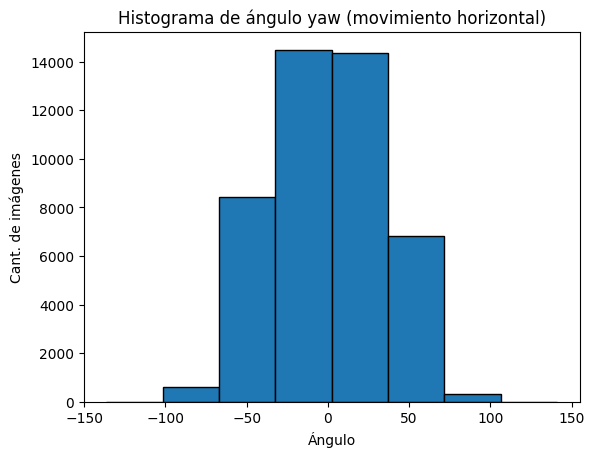

In [ ]:
yaw_array_deg = np.rad2deg(yaw_array*np.pi)
plt.hist(yaw_array_deg, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo yaw (movimiento horizontal)')
plt.show()

### 1.2.3 Proyección de ángulos 2D

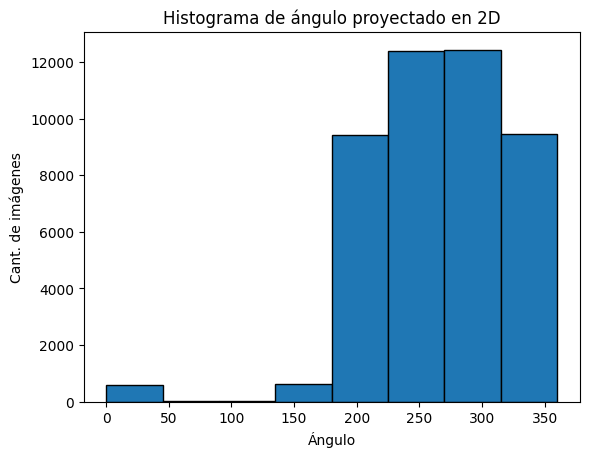

In [ ]:
plt.hist(projected_2d_angle_array, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo proyectado en 2D')
plt.show()

### 1.2.4 Quiver plot

In [ ]:
X, Y = np.meshgrid(np.arange(len(pitch_array)), np.arange(len(yaw_array)))
# Convierte yaw y pitch a vectores
U = np.cos(pitch_array)  # X
V = np.sin(yaw_array)    # Y

plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='b')

plt.xlabel('Pitch')
plt.ylabel('Yaw')
plt.title('Quiver Plot de Pitch y Yaw')

plt.grid(True)
plt.show()

: 

### 1.2.5 Polar plot

In [ ]:
# Create the polar plot
plt.polar(yaw_array, pitch_array, marker='o', linestyle='-', color='r')

# Add title
plt.title('Polar Plot of Pitch and Yaw')

# Show the plot
plt.show()

In [ ]:
from datasets import MPIIFaceGaze

In [ ]:
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", imgs_per_individual=10)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de /home/idk/git/ceia/vpc2_project/datasets/MPIIFaceGaze.h5
Se cargaron 150 imagenes


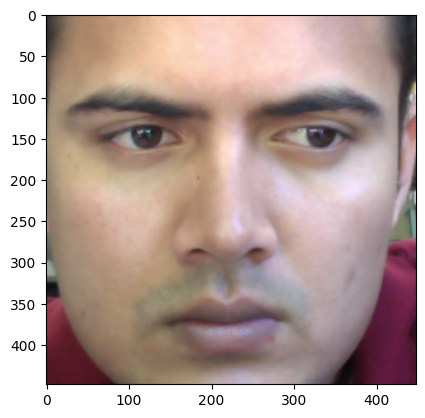

In [ ]:
plt.imshow(ds.images_list[20][:,:,::-1])

#### Creación de los set de entrenamiento y testeo

- Al usar resnet18 como capas previas (para aprovechar y hacer transfer learning), las imagenes deben ser redimensionadas a 224x224
- Data augmentation:
    - RandomResizedCrop: Se busca cortar y redimensionar la imagen aleatoreamente para generar más diversidad de datos
    - ColorJitter: Se realizan leves cambios en la saturación y el tono para garantizar más robustez ante distintas varaciones lumínicas y de color de ojos
    - No se pueden realizar transformaciones como HorizontalFlip o VerticalFlip porque alteran la posición de la mirada.

In [ ]:
WIDTH = 224 
HEIGHT = 224

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HEIGHT)),
    # torchvision.transforms.RandomHorizontalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomVerticalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.9, 1.0)),
    # torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
])


In [ ]:
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", transform=data_transforms, imgs_per_individual=100)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de /home/idk/git/ceia/vpc2_project/datasets/MPIIFaceGaze.h5
Se cargaron 1500 imagenes


In [ ]:
# Separo en entrenamiento y validacion
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Creo los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


torch.Size([64, 3, 224, 224]) torch.Size([64, 2])
pitch yaw: tensor([-0.0364, -0.3351], dtype=torch.float64)


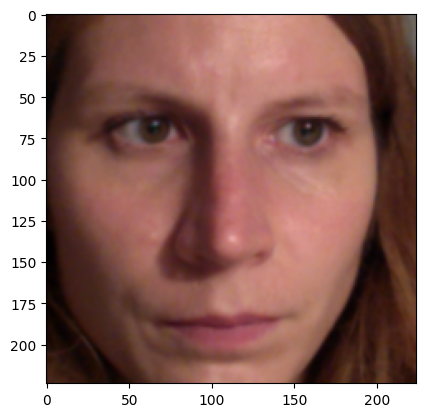

In [ ]:
train_image, train_labels = next(iter(train_loader))

print(train_image.shape, train_labels.shape)

# Grafico una imagen con el label para asegurarnos que este bien cargada 
plt.imshow(train_image[0].permute(1, 2, 0).numpy()[:,:,::-1])
print(f'pitch yaw: {train_labels[0]}')

# Entrenamiento

#### Instanciación del modelo y prueba de dimensiones

In [ ]:
from models import GazeEstimation_ResNet18
from torchsummary import summary

In [ ]:
# Instanciación del model
writer = SummaryWriter() # Para grabar logs en tensorboard
model = GazeEstimation_ResNet18(name="resnet18_first_layers_freezed",pretrained=True, debug=True)
model.dynamic_lr = False
model.lr_epochs_adjustment = 30 # Cada 30 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

resnet18.conv1.weight: No entrenable
resnet18.bn1.weight: No entrenable
resnet18.bn1.bias: No entrenable
resnet18.layer1.0.conv1.weight: No entrenable
resnet18.layer1.0.bn1.weight: No entrenable
resnet18.layer1.0.bn1.bias: No entrenable
resnet18.layer1.0.conv2.weight: No entrenable
resnet18.layer1.0.bn2.weight: No entrenable
resnet18.layer1.0.bn2.bias: No entrenable
resnet18.layer1.1.conv1.weight: No entrenable
resnet18.layer1.1.bn1.weight: No entrenable
resnet18.layer1.1.bn1.bias: No entrenable
resnet18.layer1.1.conv2.weight: No entrenable
resnet18.layer1.1.bn2.weight: No entrenable
resnet18.layer1.1.bn2.bias: No entrenable
resnet18.layer2.0.conv1.weight: Entrenable
resnet18.layer2.0.bn1.weight: Entrenable
resnet18.layer2.0.bn1.bias: Entrenable
resnet18.layer2.0.conv2.weight: Entrenable
resnet18.layer2.0.bn2.weight: Entrenable
resnet18.layer2.0.bn2.bias: Entrenable
resnet18.layer2.0.downsample.0.weight: Entrenable
resnet18.layer2.0.downsample.1.weight: Entrenable
resnet18.layer2.0.dow

In [ ]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Entrenamiento propiamente dicho

In [ ]:
model.fit(train_loader, val_loader, criterion, optimizer, epochs=100, device=device, save_model=True)

Epoch 1/60


Validation loss 0.01079: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0029 / 71.31% | Validation Loss / Accuracy: 0.0108 / 33.20%
Epoch 2/60


Validation loss 0.01115: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0028 / 74.11% | Validation Loss / Accuracy: 0.0112 / 41.99%
Epoch 3/60


Validation loss 0.01086: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0033 / 71.08% | Validation Loss / Accuracy: 0.0109 / 45.12%
Epoch 4/60


Validation loss 0.01074: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0029 / 72.91% | Validation Loss / Accuracy: 0.0107 / 32.42%
Epoch 5/60


Validation loss 0.01029: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0029 / 71.59% | Validation Loss / Accuracy: 0.0103 / 41.41%
Epoch 6/60


Validation loss 0.01067: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 75.30% | Validation Loss / Accuracy: 0.0107 / 42.77%
Epoch 7/60


Validation loss 0.01034: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0030 / 72.17% | Validation Loss / Accuracy: 0.0103 / 40.62%
Epoch 8/60


Validation loss 0.01315: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0028 / 72.91% | Validation Loss / Accuracy: 0.0132 / 40.23%
Epoch 9/60


Validation loss 0.01151: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0028 / 73.78% | Validation Loss / Accuracy: 0.0115 / 34.77%
Epoch 10/60


Validation loss 0.01075: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0028 / 73.86% | Validation Loss / Accuracy: 0.0108 / 35.55%
Epoch 11/60


Validation loss 0.01477: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0028 / 75.50% | Validation Loss / Accuracy: 0.0148 / 35.35%
Epoch 12/60


Validation loss 0.01189: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0025 / 76.91% | Validation Loss / Accuracy: 0.0119 / 34.57%
Epoch 13/60


Validation loss 0.01167: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 75.03% | Validation Loss / Accuracy: 0.0117 / 34.77%
Epoch 14/60


Validation loss 0.01205: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 75.38% | Validation Loss / Accuracy: 0.0120 / 42.19%
Epoch 15/60


Validation loss 0.01246: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 74.94% | Validation Loss / Accuracy: 0.0125 / 37.50%
Epoch 16/60


Validation loss 0.01108: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 73.91% | Validation Loss / Accuracy: 0.0111 / 39.65%
Epoch 17/60


Validation loss 0.01230: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0025 / 76.35% | Validation Loss / Accuracy: 0.0123 / 42.97%
Epoch 18/60


Validation loss 0.01041: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 77.01% | Validation Loss / Accuracy: 0.0104 / 43.95%
Epoch 19/60


Validation loss 0.01052: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0026 / 75.67% | Validation Loss / Accuracy: 0.0105 / 36.52%
Epoch 20/60


Validation loss 0.00981: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0026 / 78.15% | Validation Loss / Accuracy: 0.0098 / 41.41%
Epoch 21/60


Validation loss 0.00998: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0025 / 77.14% | Validation Loss / Accuracy: 0.0100 / 49.61%
Epoch 22/60


Validation loss 0.00990: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0025 / 78.84% | Validation Loss / Accuracy: 0.0099 / 42.97%
Epoch 23/60


Validation loss 0.01007: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 77.14% | Validation Loss / Accuracy: 0.0101 / 41.21%
Epoch 24/60


Validation loss 0.01240: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 76.25% | Validation Loss / Accuracy: 0.0124 / 36.13%
Epoch 25/60


Validation loss 0.00957: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0025 / 77.18% | Validation Loss / Accuracy: 0.0096 / 43.95%
Epoch 26/60


Validation loss 0.01033: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 76.58% | Validation Loss / Accuracy: 0.0103 / 36.52%
Epoch 27/60


Validation loss 0.01012: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 80.22% | Validation Loss / Accuracy: 0.0101 / 48.44%
Epoch 28/60


Validation loss 0.00974: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 79.25% | Validation Loss / Accuracy: 0.0097 / 42.19%
Epoch 29/60


Validation loss 0.00996: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 78.92% | Validation Loss / Accuracy: 0.0100 / 43.16%
Epoch 30/60


Validation loss 0.01116: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 78.67% | Validation Loss / Accuracy: 0.0112 / 42.19%
Epoch 31/60


Validation loss 0.01081: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 76.46% | Validation Loss / Accuracy: 0.0108 / 41.99%
Epoch 32/60


Validation loss 0.01092: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 77.59% | Validation Loss / Accuracy: 0.0109 / 37.89%
Epoch 33/60


Validation loss 0.01022: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 77.57% | Validation Loss / Accuracy: 0.0102 / 44.53%
Epoch 34/60


Validation loss 0.01066: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 79.98% | Validation Loss / Accuracy: 0.0107 / 43.16%
Epoch 35/60


Validation loss 0.00970: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 76.87% | Validation Loss / Accuracy: 0.0097 / 35.35%
Epoch 36/60


Validation loss 0.01032: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 80.16% | Validation Loss / Accuracy: 0.0103 / 43.75%
Epoch 37/60


Validation loss 0.01060: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 80.62% | Validation Loss / Accuracy: 0.0106 / 36.72%
Epoch 38/60


Validation loss 0.00987: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 78.88% | Validation Loss / Accuracy: 0.0099 / 38.28%
Epoch 39/60


Validation loss 0.01000: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 77.48% | Validation Loss / Accuracy: 0.0100 / 42.77%
Epoch 40/60


Validation loss 0.01017: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 78.20% | Validation Loss / Accuracy: 0.0102 / 43.75%
Epoch 41/60


Validation loss 0.01404: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 80.66% | Validation Loss / Accuracy: 0.0140 / 38.48%
Epoch 42/60


Validation loss 0.01149: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 79.08% | Validation Loss / Accuracy: 0.0115 / 38.28%
Epoch 43/60


Validation loss 0.00981: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 77.99% | Validation Loss / Accuracy: 0.0098 / 44.92%
Epoch 44/60


Validation loss 0.00911: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 78.99% | Validation Loss / Accuracy: 0.0091 / 51.17%
Epoch 45/60


Validation loss 0.01153: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 80.81% | Validation Loss / Accuracy: 0.0115 / 43.36%
Epoch 46/60


Validation loss 0.00967: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 81.67% | Validation Loss / Accuracy: 0.0097 / 44.73%
Epoch 47/60


Validation loss 0.01175: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 79.16% | Validation Loss / Accuracy: 0.0117 / 38.28%
Epoch 48/60


Validation loss 0.00905: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 81.62% | Validation Loss / Accuracy: 0.0091 / 51.76%
Epoch 49/60


Validation loss 0.01153: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 81.68% | Validation Loss / Accuracy: 0.0115 / 44.34%
Epoch 50/60


Validation loss 0.00944: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 79.76% | Validation Loss / Accuracy: 0.0094 / 50.78%
Epoch 51/60


Validation loss 0.00969: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 81.06% | Validation Loss / Accuracy: 0.0097 / 43.55%
Epoch 52/60


Validation loss 0.00989: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 80.90% | Validation Loss / Accuracy: 0.0099 / 42.58%
Epoch 53/60


Validation loss 0.00981: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 81.14% | Validation Loss / Accuracy: 0.0098 / 44.73%
Epoch 54/60


Validation loss 0.01023: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 83.20% | Validation Loss / Accuracy: 0.0102 / 47.07%
Epoch 55/60


Validation loss 0.00960: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 79.33% | Validation Loss / Accuracy: 0.0096 / 41.21%
Epoch 56/60


Validation loss 0.01185: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 82.02% | Validation Loss / Accuracy: 0.0118 / 46.88%
Epoch 57/60


Validation loss 0.00925: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 83.29% | Validation Loss / Accuracy: 0.0093 / 41.02%
Epoch 58/60


Validation loss 0.01076: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 82.50% | Validation Loss / Accuracy: 0.0108 / 38.67%
Epoch 59/60


Validation loss 0.01038: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 81.97% | Validation Loss / Accuracy: 0.0104 / 42.97%
Epoch 60/60


Validation loss 0.00971: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 81.74% | Validation Loss / Accuracy: 0.0097 / 50.78%


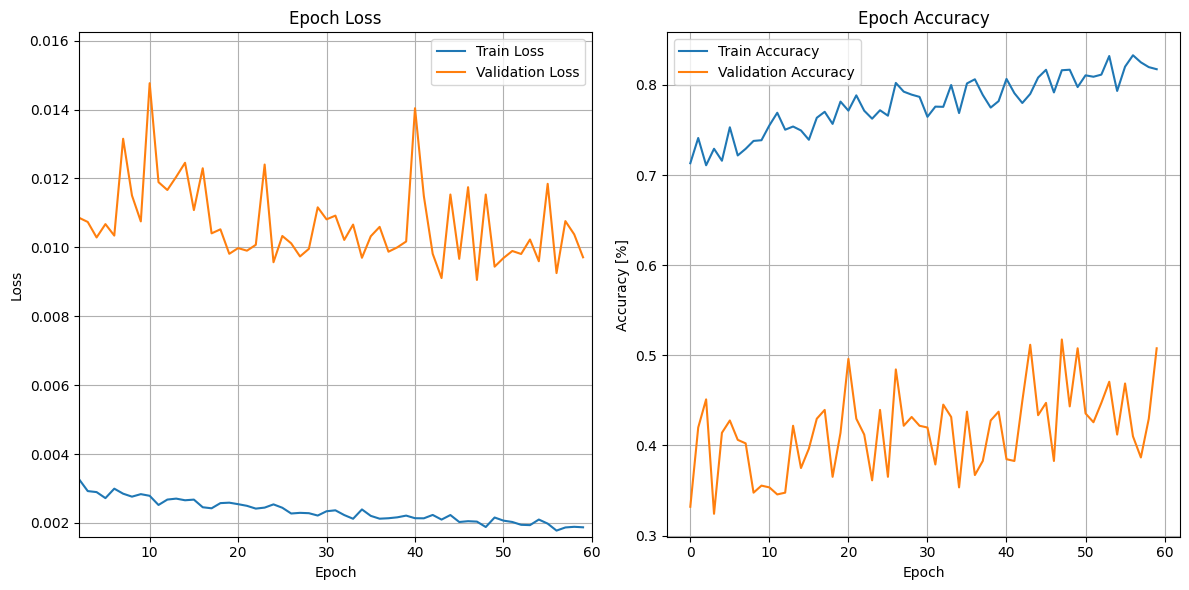

In [ ]:
# Grafico las curvas de entrenamiento y validacion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Loss subplot
ax1.set_title("Epoch Loss")
ax1.plot(range(len(model.epoch_train_loss)), model.epoch_train_loss, label='Train Loss')
ax1.plot(range(len(model.epoch_val_loss)), model.epoch_val_loss, label='Validation Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()  

# Zoom en curvas de loss, se evitan los primeros 'start_val' valores 
# que tienen loss muy alto y no dejan ver bien el resto
start_val = 2
if len(model.epoch_val_loss) > start_val:
    ax1.set_xlim([start_val,len(model.epoch_val_loss)])
    ax1.set_ylim([min(model.epoch_val_loss[start_val:]+model.epoch_train_loss[start_val:])*0.9,
                  max(model.epoch_val_loss[start_val:]+model.epoch_train_loss[start_val:])*1.1])

# Accuracy subplot
ax2.set_title("Epoch Accuracy")
ax2.plot(range(len(model.epoch_train_accuracy)), model.epoch_train_accuracy, label='Train Accuracy')
ax2.plot(range(len(model.epoch_val_accuracy)), model.epoch_val_accuracy, label='Validation Accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy [%]")
ax2.grid(True)
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Para probar que se haya guardado bien el mejor modelo entrenado
new_model = GazeEstimation_ResNet18()
new_model.load_state_dict(torch.load('./modelos/resnet18_freezed.pth'))
new_model.to(device)

inputs = torch.randn(8, 3, 224, 224).to(device)  # Batch of 8 images, 3 channels (RGB), 224x224 resolution
outputs = new_model(inputs)  # Outputs will be the predicted yaw and pitch angles

print(outputs)

/tmp/ipykernel_1608443/3003497342.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('./modelos/resnet18_freezed.pth'))


tensor([[-0.1625,  0.0727],
        [-0.0903,  0.0671],
        [-0.2182,  0.0508],
        [-0.1455, -0.0662],
        [-0.2481,  0.0161],
        [-0.2063, -0.0771],
        [-0.1804, -0.0041],
        [-0.2120,  0.0603]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Validación

Se toma una imagen al azar y se visualiza la dirección de la mirada actual VS la predicha
- Flecha azul: indica la posición de la mirada verdadera.
- Flecha verde: indica la posición de la mirada predicha por el modelo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Actual: 
	 pitch=-0.011 rad | yaw=0.124 rad
	 proyección 2D del ángulo: 185.23° deg
Predicted: 
	 pitch=-0.068 rad | yaw=0.114 rad
	 proyección 2D del ángulo: 210.74° deg
**Preciso (tolerancia = 15°): 0


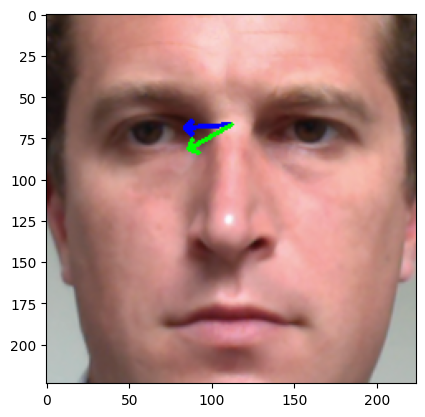

In [ ]:


# Se elige imagen al azar y se obtienen sus labesl (pitch,yaw)
img, gaze = test_dataset[randint(0,len(test_dataset)-1)]
pitch = gaze[0]
yaw = gaze[1]
angle = angle_to_2d(np.array([gaze]))

# Ahora se pasa la imagen por el modelo y se obtiene la predicción
predicted_gaze = model(img.unsqueeze(0).to(device))
pitch_predicted = predicted_gaze[0][0].item()
yaw_predicted = predicted_gaze[0][1].item()
img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze.squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

# Se define la tolerancia para considerar una predicción como precisa o no 
tolerancia = 15 # 15° de tolerancia para considerar una predicción como error
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

# Impresión de parámetros
print("Actual: ")
print(f"\t pitch={pitch:.3f} rad | yaw={yaw:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print(f"\t pitch={pitch_predicted:.3f} rad | yaw={yaw_predicted:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

# Se agregan anotaciones a la imagen
img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0)) #Actual: flecha azul
img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0)) #Prediced: flecha verde

# Mostrar imagen (se convierte a RGB porque openCV trabaja en BGR)
plt.imshow(rgb(img))

# Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1793849), started 0:00:05 ago. (Use '!kill 1793849' to kill it.)